In [1]:
!pip install ucimlrepo

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import plotly.express as px
from math import floor
from sklearn.model_selection import train_test_split

1. PICO formulation

Why would a patient be early readmitted in the first place? Here are a few hypotheses:

Patient is not adequately diagnosed as diabetic on the first admission;
Ineffectiveness of treatment during past hospitalizations, namely
insufficient number of exams;
insufficient medical intervention (medication change or procedures);
Poor patient health.

Suggestion:

**Population** : diabetic hospitalized population ; \
**Intervention** : HbA1c test (allowing being adequately diagnosed as diabetic) ; \
**Comparaison** : diabetic without measurement ; \
**Résultat** : readmission (<30days).

The data set used for this task is the Diabetes 130-US hospitals for years 1999-2008 Data Set, containing anonymized medical data collected during 100k encounters across several hospitals in the United States, made available by Strack et al. (2014).

2. Data analysis

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets
df = pd.concat([X, y], axis=1)

# metadata
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata)

# variable information
print(diabetes_130_us_hospitals_for_years_1999_2008.variables)

{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [4]:
print(diabetes_130_us_hospitals_for_years_1999_2008.data.targets.value_counts(normalize=True))

readmitted
NO            0.539119
>30           0.349282
<30           0.111599
Name: proportion, dtype: float64


Our study focuses on readmission ("<30") representing 11% of the sample. Our aim will be to measure the impact of HbA1c measurement on readmission.
HbA1c not only provides a reliable measure of chronic hyperglycemia, but is also well correlated with the risk of long-term diabetes complications. It is therefore crucial for a correct diagnosis.


Source: https://translate.google.com/translate?u=https://pmc.ncbi.nlm.nih.gov/articles/PMC4933534/&hl=fr&sl=en&tl=fr&client=rq&prev=search#:~:text=HbA1c%20not%20only%20provides%20a,subjects%20with%20or%20without%20diabetes

In [5]:
print("Variable              Unique     % Missing  Examples")
print("="*100)
for column in X:
    uniques = set(X[column])
    n_uniques = len(uniques)
    missing = X[column].isnull().mean()*100
    examples = list(uniques)[:5]
    output = "{:<25} {:<10} {:<6.1f} {:<20}".format(column, n_uniques, missing, str(examples))
    print(output)

Variable              Unique     % Missing  Examples
race                      6          2.2    [nan, 'Asian', 'Other', 'Caucasian', 'Hispanic']
gender                    3          0.0    ['Female', 'Unknown/Invalid', 'Male']
age                       10         0.0    ['[90-100)', '[80-90)', '[30-40)', '[50-60)', '[70-80)']
weight                    10         96.9   ['[175-200)', '[25-50)', '[125-150)', nan, '[0-25)']
admission_type_id         8          0.0    [1, 2, 3, 4, 5]     
discharge_disposition_id  26         0.0    [1, 2, 3, 4, 5]     
admission_source_id       17         0.0    [1, 2, 3, 4, 5]     
time_in_hospital          14         0.0    [1, 2, 3, 4, 5]     
payer_code                16402      39.6   [nan, nan, nan, nan, nan]
medical_specialty         73         49.1   ['Otolaryngology', 'Anesthesiology', 'Pediatrics-CriticalCare', 'Surgery-Cardiovascular', 'Urology']
num_lab_procedures        118        0.0    [1, 2, 3, 4, 5]     
num_procedures            7       

In [6]:
df.head()

race  gender      age weight  admission_type_id  \
0        Caucasian  Female   [0-10)    NaN                  6   
1        Caucasian  Female  [10-20)    NaN                  1   
2  AfricanAmerican  Female  [20-30)    NaN                  1   
3        Caucasian    Male  [30-40)    NaN                  1   
4        Caucasian    Male  [40-50)    NaN                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital payer_code  \
0                        25                    1                 1        NaN   
1                         1                    7                 3        NaN   
2                         1                    7                 2        NaN   
3                         1                    7                 2        NaN   
4                         1                    7                 1        NaN   

          medical_specialty  ...  citoglipton  insulin  glyburide-metformin  \
0  Pediatrics-Endocrinology  ...           No       No                   No   
1                       NaN  ...           No       Up                   No   
2                       NaN  ...           No       No                   No   
3                       NaN  ...           No       Up                   No   
4                       NaN  ...           No   Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

  metformin-pioglitazone change diabetesMed  readmitted  
0                     No     No          No          NO  
1                     No     Ch         Yes         >30  
2                     No     No         Yes          NO  
3                     No     Ch         Yes          NO  
4                     No     Ch         Yes          NO  

[5 rows x 48 columns]

In [7]:
race = pd.DataFrame(X['race'])
fig = px.pie(race, names='race', title='Distribution of Race')
fig.show()

age = pd.DataFrame(X['age'])
fig = px.pie(age, names='age', title='Distribution of Age')
fig.show()

gender = pd.DataFrame(X['gender'])
fig = px.pie(gender, names='gender', title='Distribution of Gender')
fig.show()

weight = pd.DataFrame(X['weight'])
fig = px.pie(weight, names='weight', title='Distribution of Weight')
fig.show()

In [8]:
readmitted_age = df[df["readmitted"] == "<30"]["age"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

readmitted_age

age
[0-10)      0.000264
[10-20)     0.003522
[20-30)     0.020780
[90-100)    0.027296
[30-40)     0.037334
[40-50)     0.090429
[50-60)     0.146870
[80-90)     0.182971
[60-70)     0.220305
[70-80)     0.270230
Name: proportion, dtype: float64

In [9]:
nonreadmitted_age = df[df["readmitted"] != "<30"]["age"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

nonreadmitted_age

age
[0-10)      0.001748
[10-20)     0.007201
[20-30)     0.015717
[90-100)    0.027464
[30-40)     0.037065
[40-50)     0.095765
[80-90)     0.167229
[50-60)     0.172416
[60-70)     0.221007
[70-80)     0.254388
Name: proportion, dtype: float64

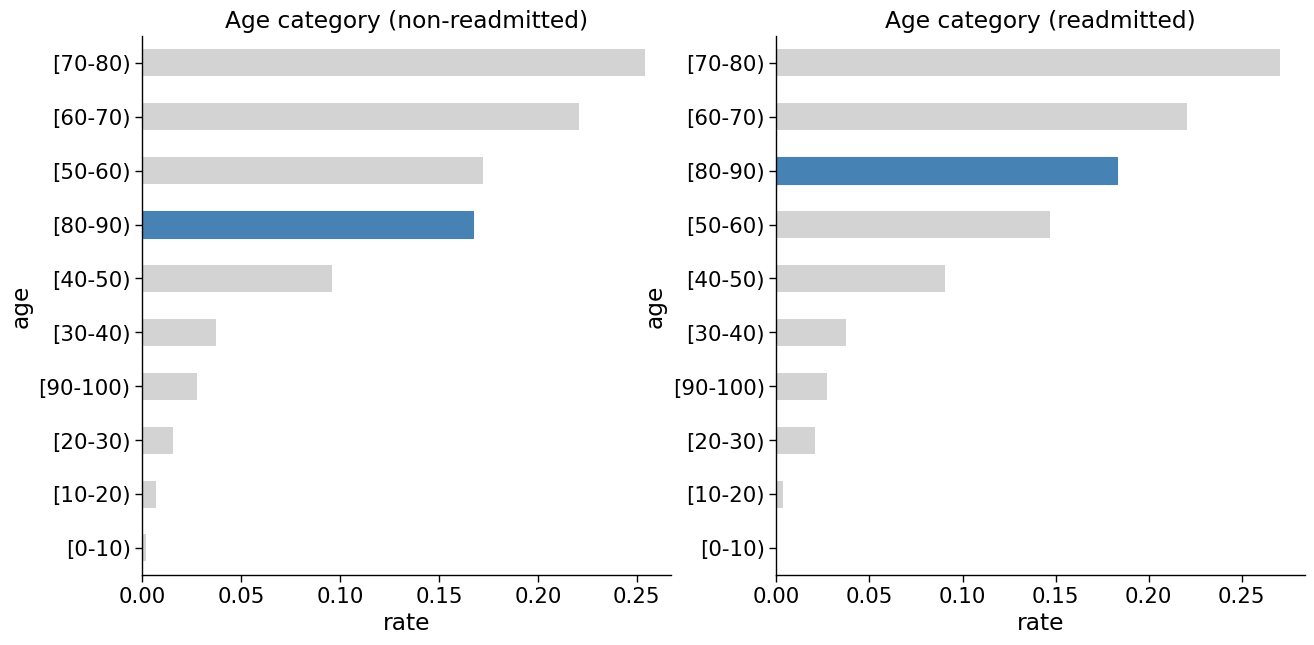

In [10]:
sns.set_context('paper', font_scale=1.75)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

nonreadmitted_age.plot(kind="barh", title="Age category (non-readmitted)", color="lightgray", ax=ax1)
readmitted_age.plot(kind="barh", title="Age category (readmitted)", color="lightgray", ax=ax2)

ax1.set_xlabel("rate")
ax2.set_xlabel("rate")

ax1.patches[6].set_color("steelblue")
ax2.patches[7].set_color("steelblue")

sns.despine()

plt.savefig("/content/topage.png")
plt.show()

3. Data processing

In [11]:
# Keeping the original df intact in case we need it
df2 = df.copy()

In [12]:
#A few rows in the data set refer to the same patient number (patient_nbr). Most machine learning models require the observations to be independent of each other. More specifically, the assumption is that observations should not come from repeated measurements. To ensure our model's robustness, duplicated entries for the same patient will be deleted (while keeping the first appearance only).
#print("df size before:", df.shape[0])
#df2 = df2.drop_duplicates(subset="patient_nbr", keep="first")
#print("df size after:", df2.shape[0])

In [13]:
#encounter_id, patient_nbr, and payer_code: irrelevant to patient outcome
#weight, medical_specialty: too many missing values.
#admission_source_id: redundant variable (admission_type_id already contains information about the admission)
#all medications (including the most common: metformin, glimepiride, glipizide, glyburide, pioglitazone, rosiglitazone, and insulin): they either correlated strongly with diabetesMed, which indicates if there's any diabetic medication prescribed, or not used at all.
df2 = df2.drop(["payer_code",
                "weight",
                "medical_specialty",
                "admission_source_id",
                "metformin",
                "glimepiride",
                "glipizide",
                "glyburide",
                "pioglitazone",
                "rosiglitazone",
                "insulin",
                "repaglinide",
                "nateglinide",
                "chlorpropamide",
                "acetohexamide",
                "tolbutamide",
                "acarbose",
                "miglitol",
                "troglitazone",
                "tolazamide",
                "examide",
                "citoglipton",
                "glyburide-metformin",
                "glipizide-metformin",
                "glimepiride-pioglitazone",
                "metformin-rosiglitazone",
                "metformin-pioglitazone",
                ], axis=1)

In [14]:
df2.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

In [15]:
age_map = {'[0-10)': 0,
           '[10-20)': 1,
           '[20-30)': 2,
           '[30-40)': 3,
           '[40-50)': 4,
           '[50-60)': 5,
           '[60-70)': 6,
           '[70-80)': 7,
           '[80-90)': 8,
           '[90-100)': 9}

df2["age"].replace(age_map, inplace=True)

<ipython-input-15-6f6e985e54eb>:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-15-6f6e985e54eb>:12: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [16]:
df2["gender"] = df2["gender"].apply(lambda x: 1 if x == "Female" else 0)

In [17]:
df2["emergency"] = df2["admission_type_id"].apply(lambda x: 1 if x in [1, 2] else 0)
df2.drop("admission_type_id", axis=1, inplace=True)

In [18]:
df2["sent_home"] = df2["discharge_disposition_id"].apply(lambda x: 1 if x in [1, 6, 8] else 0)
df2.drop("discharge_disposition_id", axis=1, inplace=True)

In [19]:
# Make it easier to enter ICD-9 ranges in the dictionary
interval = lambda x,y: list(range(x,y+1))

diag = {
    "Circulatory": interval(390, 433) + interval(435, 459) + [785],  # except 434
    "Respiratory": interval(460,519) + [786],
    "Digestive": interval(520,579) + [786],
    "Diabetes": [250],  # makes sense to give Diabetes a group for its own
    "Injury": interval(800,999),
    "Musculoskeletal": interval(710,739),
    "Genitourinary": interval(580,629) + [788],
    "Neoplasms": interval(140,239),
    "Endocrine": interval(240,249) + interval(251,279),  # except 250
    "General symptoms": [780,781,784] + interval(790,799),  # among thedupl top 10 for non-readmitted
    "Skin": interval(680,709) + [782],
    "Infection": interval(1,139),
    "Mental": interval(290,319),
    "External causes": [1000],  # passed by icd() as 1000, but the code doesn't exist officially
    "Blood": interval(280,289),
    "Nervous": interval(320,359),
    "Pregnancy": interval(630,679),
    "Sense organs": interval(360,389),
    "Congenital": interval(740, 759),
    "Occlusion of cerebral arteries": [434], # among the top 10 for readmitted
    "Unknown": [-1]
}

def icd(code):
    """Converts ICD-9 code in string format into a descriptive major category.
    ---
    code : int
    The ICD-9 encoded diagonisis

    return : str
    A major diagnostic category.
    """
    if (code[0] != "V") and (code[0] != "E"):
        code = floor(float(code))
    else:
        code = 1000
    for key in diag:
        if code in diag[key]:
            return key

In [20]:
df2["diag_1"] = df2["diag_1"].fillna("-1").apply(icd)
df2["diag_2"] = df2["diag_2"].fillna("-1").apply(icd)
df2["diag_3"] = df2["diag_3"].fillna("-1").apply(icd)

In [21]:
df2["A1Cresult"] = df2["A1Cresult"].map({"None": -1, "Norm": 0, ">7": 1, ">8": 2})
df2["max_glu_serum"] = df2["max_glu_serum"].map({"None": -1, "Norm": 0, ">200": 1, ">300": 2})

In [22]:
df2["A1C_tested"] = df2["A1Cresult"].apply(lambda x: 0 if x == -1 else 1)
df2["max_glu_serum_tested"] = df2["max_glu_serum"].apply(lambda x: 0 if x == -1 else 1)

In [23]:
df2["change"] = df2["change"].apply(lambda x: 1 if x == "Ch" else 0)

In [24]:
df2["diabetesMed"] = df2["diabetesMed"].apply(lambda x: 1 if x == "Yes" else 0)

In [25]:
df2['readmitted'] = df2['readmitted'].apply(lambda x: 1 if x == "<30" else 0)

In [26]:
df2 = pd.get_dummies(df2, dummy_na=False, drop_first=False)

In [27]:
for disease in diag:
    df2[f"diag_{disease}"] = df2[f"diag_1_{disease}"]*3 + df2[f"diag_2_{disease}"]*2 + df2[f"diag_3_{disease}"]*1
    df2.drop([f"diag_{n}_{disease}" for n in range(1,4)], axis=1, inplace=True)

In [28]:
# Define target variable and features space.
y = df2['readmitted'].values
X = df2.drop("readmitted", axis=1).values

# 75/25 split of the data into training/test sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

NameError: name 'train_test_split' is not defined

TODO: add correlation of DiabMed & HbA1c test/results

4. Model for impact evaluation

TODO General idea: The goal here is to demonstrate that, compared to "control" individuals (e.g., those with the same likelihood of having diabetes), individuals who underwent the HbA1c test are less likely to be readmitted. This suggests that the test may lead to more accurate diagnoses and better management of the condition.


TODO: https://medium.com/@med.hmamouch99/double-machine-learning-for-causal-inference-a-practical-guide-5d85b77aa586